In [1]:
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchsummary import summary

import os
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm
import time
import gc

In [3]:
# import shutil
# shutil.rmtree('/content/dataA')

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

### Datset

In [5]:
rgb_dir = "/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB"
seg_dir = "/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg"
data = pd.DataFrame({'rgb_files':[os.path.join(rgb_dir, file_) for file_ in sorted(os.listdir(rgb_dir))],
                     'seg_files':[os.path.join(seg_dir, file_) for file_ in sorted(os.listdir(seg_dir))]})
data.shape, data.head(2)

((1000, 2),
                                            rgb_files  \
 0  /kaggle/input/lyft-udacity-challenge/dataA/dat...   
 1  /kaggle/input/lyft-udacity-challenge/dataA/dat...   
 
                                            seg_files  
 0  /kaggle/input/lyft-udacity-challenge/dataA/dat...  
 1  /kaggle/input/lyft-udacity-challenge/dataA/dat...  )

---

In [6]:
# rgb_images = []
# for rgb_file in tqdm.tqdm(data['rgb_files']):
#     rgb_images.append(transforms.ToTensor()(Image.open(rgb_file)))
# len(rgb_images), type(rgb_images[0]), rgb_images[0].shape

In [7]:
# np.save('rgb_images.npy', np.array(rgb_images, dtype=object), allow_pickle=True)

In [8]:
toSegment = [7]
num_classes = len(toSegment) + 1
dict_ = dict(zip(toSegment, range(1, num_classes))) #0-everything background
inv_dict_ = {v: k for k, v in dict_.items()}
dict_, inv_dict_

({7: 1}, {1: 7})

In [9]:
WIDTH, HEIGHT = 150, 200

act_width, act_height = 600, 800   # Get dimensions
left = (act_width - WIDTH)/2
top = (act_height - HEIGHT)/2
right = (act_width + WIDTH)/2
bottom = (act_height + HEIGHT)/2

In [10]:
def mapping(a, dict_):
    return dict_.get(a, 0)

def inv_mapping(a, inv_dict_):
    return inv_dict_.get(a, 0)

mapping_v = np.vectorize(mapping)
inv_mapping_v = np.vectorize(inv_mapping)

In [11]:
# img = np.asarray(Image.open(data['seg_files'][0]))
# mask = np.max(img, axis=2)
# mask = mapping_v(mask, dict_)
# # mask = np.array([max(img[i, j]) for i in range(img.shape[0]) for j in range(img.shape[1])]).reshape(img.shape[0], img.shape[1])
# mask.shape, np.unique(mask, return_counts=True)

In [12]:
# mask = mapping_v(mask, dict_)

In [13]:
# mask.shape, np.unique(mask, return_counts=True)

In [14]:
# mask = inv_mapping_v(mask, inv_dict_)
# mask.shape, np.unique(mask, return_counts=True)

In [15]:
# seg_images = []
# for seg_file in tqdm.tqdm(data['seg_files']):
#     mask = np.asarray(Image.open(data['seg_files'][0]))
#     mask = np.max(mask, axis=2)
#     mask = mapping_v(mask, dict_)
#     seg_images.append(torch.Tensor(mask).to(torch.int64))
#     # img_array = np.asarray(Image.open(seg_file))
#     # img_array = np.max(img_array, axis=2)
#     # seg_images.append(np.where(np.isin(img_array, toSegment), img_array, 0))
#     # seg_images.append(np.array([max(img_array[i, j]) if max(img_array[i, j]) in toSegment else 0 for i in range(img_array.shape[0]) for j in range(img_array.shape[1])]).reshape(img_array.shape[0], img_array.shape[1]))
# len(seg_images), type(seg_images[0]), seg_images[0].shape

In [16]:
# plt.imshow(rgb_images[0].permute(1, 2, 0))

In [17]:
# plt.imshow(seg_images[0], cmap='Paired')

In [18]:
def preprocess(rgb_file, seg_file):
    mask = np.asarray(Image.open(seg_file).crop((left, top, right, bottom)))
    mask = np.max(mask, axis=2)
    mask = mapping_v(mask, dict_)
    return transforms.ToTensor()(Image.open(rgb_file).crop((left, top, right, bottom))).to(DEVICE), torch.Tensor(mask).to(torch.int64).to(DEVICE)

In [19]:
# rgb_processed, seg_processed = preprocess(rgb_images[0], seg_images[0])
# print(f'rgb_processed-> {rgb_processed.shape} -> {torch.max(rgb_processed)} -> {torch.min(rgb_processed)}')
# print(f'seg_processed-> {seg_processed.shape} -> {torch.max(seg_processed)} -> {torch.min(seg_processed)}')

In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, use_cache=False, preprocess=None):
        self.size = len(data)
        self.use_cache = use_cache
        self.preprocess = preprocess
    def __getitem__(self, index):
        if self.use_cache and (index in self.cached_data):
            return self.cached_data[index]
        rgb_file, seg_file = data['rgb_files'][index], data['seg_files'][index]
        x_ = [rgb_file, seg_file]
        if self.preprocess != None:
            x_[0], x_[1] = self.preprocess(rgb_file, seg_file)
        if self.use_cache:
            self.cached_data[index] = x_
        return x_
    def __len__(self):
        return self.size

In [21]:
dataset = MyDataset(data, use_cache=False, preprocess=preprocess)

In [22]:
train_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
print(f'train_dataset size={len(train_dataset)} and test_dataset size={len(test_dataset)}')

train_dataset size=800 and test_dataset size=200


In [23]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)#, num_workers=1, prefetch_factor=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)#, num_workers=1, prefetch_factor=2)

In [24]:
batch = next(iter(train_dataloader))
batch[0].shape, batch[0][0].shape, batch[1].shape, batch[1][0].shape

(torch.Size([64, 3, 200, 150]),
 torch.Size([3, 200, 150]),
 torch.Size([64, 200, 150]),
 torch.Size([200, 150]))

### Model

[link](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py)

In [25]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [26]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [27]:
model = UNet(3, num_classes).to(DEVICE)

In [28]:
summary(model, (3, 600, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 600, 800]           1,728
       BatchNorm2d-2         [-1, 64, 600, 800]             128
              ReLU-3         [-1, 64, 600, 800]               0
            Conv2d-4         [-1, 64, 600, 800]          36,864
       BatchNorm2d-5         [-1, 64, 600, 800]             128
              ReLU-6         [-1, 64, 600, 800]               0
        DoubleConv-7         [-1, 64, 600, 800]               0
         MaxPool2d-8         [-1, 64, 300, 400]               0
            Conv2d-9        [-1, 128, 300, 400]          73,728
      BatchNorm2d-10        [-1, 128, 300, 400]             256
             ReLU-11        [-1, 128, 300, 400]               0
           Conv2d-12        [-1, 128, 300, 400]         147,456
      BatchNorm2d-13        [-1, 128, 300, 400]             256
             ReLU-14        [-1, 128, 3

---

In [29]:
def get_onehot(seg_image):
    return F.one_hot(seg_image, num_classes).to(torch.float16).permute(0, 3, 1, 2)

In [30]:
def get_image(outputs):
    outputs = torch.argmax(outputs.detach().cpu(), dim=1, keepdim=False).numpy()
    return inv_mapping_v(outputs, inv_dict_)

In [31]:
def plot_images(batch, idxToDsiplay=None, display=(1, 8), cmap='gray'):
    if not isinstance(batch,(np.ndarray)):
        batch = batch.detach().cpu()
    if len(batch.shape)==3:
        if not isinstance(batch,(np.ndarray)):
            batch = batch.unsqueeze(1)
        else:
            batch = np.expand_dims(batch, 1)
    fig = plt.figure()
    rng = np.random.default_rng()
    if idxToDsiplay is None:
        idxToDsiplay = rng.choice(batch.shape[0], size=min(batch.shape[0], display[0]*display[1]), replace=batch.shape[0]<(display[0]*display[1]))
    for i, idx in enumerate(idxToDsiplay):
        ax = fig.add_subplot(display[0], display[1], i+1)
        if not isinstance(batch,(np.ndarray)):
            ax.imshow(batch[idx].permute(1, 2, 0), cmap=cmap)
        else:
            ax.imshow(batch[idx].transpose(1, 2, 0), cmap=cmap)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    plt.subplots_adjust(wspace=0.08, hspace=-0.65)
    plt.show()
    return idxToDsiplay

In [32]:
batch[0].shape, batch[0][0].shape, batch[1].shape

(torch.Size([64, 3, 200, 150]),
 torch.Size([3, 200, 150]),
 torch.Size([64, 200, 150]))

In [33]:
outputs = model(batch[0])
outputs.shape

torch.Size([64, 2, 200, 150])

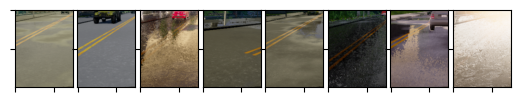

In [34]:
idx_ = plot_images(batch[0], cmap='viridis')

---

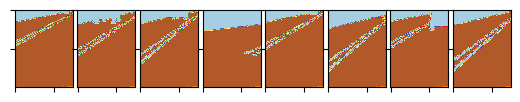

In [35]:
plot_images(batch[1], idxToDsiplay=idx_, cmap='Paired');

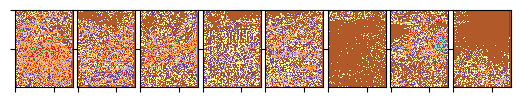

In [36]:
plot_images(get_image(outputs), idxToDsiplay=idx_, cmap='Paired');

In [37]:
batch[1] = get_onehot(batch[1])
batch[1].shape

torch.Size([64, 2, 200, 150])

In [38]:
nn.CrossEntropyLoss()(outputs, batch[1])

tensor(0.6800, grad_fn=<DivBackward1>)

In [39]:
# loss = nn.CrossEntropyLoss()
# loss(outputs, batch[1])

### Training

In [40]:
# NUM_EPOCHS = 30
# LR = 0.001
# BASE_PATH = '/kaggle/working/'
# model = model

In [41]:
class Task():
    '''This class helps in efficiently training pytorch model easily'''
    def __init__(self, model,
                 BASE_PATH,
                 train_dataloader,
                 val_dataloader=None,
                 DEVICE='cpu',
                 lr=0.001):
        self.model = model
        self.BASE_PATH = BASE_PATH #path where the output from training will be saved
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.DEVICE = DEVICE #device type 'cuda' or 'cpu'
        self.lr = lr   # model learning rate
        self.optimizer = self.get_optimizer()
        self.scheduler = self.get_scheduler()
        self.version_dir = None
        self.history = {} # dictionary that stores loss and other metrices each epoch

    def get_scheduler(self):
        '''reurn a scheduler'''
        return torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                   factor=0.8, patience=5,
                                                   threshold=0.001, threshold_mode='rel',
                                                   cooldown=2, min_lr=0.001,
                                                   eps=1e-08, verbose=False)

    def get_loss(self, input_, target):
        '''write the loss function here'''
        return nn.CrossEntropyLoss()(input_, target)
#         loss = nn.CrossEntropyLoss()
        #print(type(input_), type(input_[0][0][0]), type(target), type(target[0][0][0]),)
#         return loss(input_, target)
        # RECON = torch.nn.functional.mse_loss(output, y, reduction='sum')
        # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        # return RECON + KLD, RECON, KLD
        #print(output.shape, y.shape)
        #loss = torch.nn.MSELoss()
        # return loss(output, y)

    def plot_images(self, X, outputs):
        '''this fuunction is called for plotting images in between trainng'''
        idxToPlot = plot_images(X)
        plot_images(outputs, idxToDsiplay=idxToPlot)

    def get_optimizer(self):
        '''return optimizer'''
        return torch.optim.Adam(self.model.parameters(), self.lr, weight_decay=1e-5)

    def get_version_dir(self):
        '''this function return the new folder name for saving the output of current training run'''
        versions = [f.name for f in os.scandir(self.BASE_PATH) if f.is_dir() and f.name.startswith('Version')]
        curr_version = None
        if len(versions)==0:
            curr_version = 'Version0'
        else:
            curr_version = f'Version{int(versions[-1][7:])+1}'
        PATH = os.path.join(self.BASE_PATH, curr_version)
        if not os.path.exists(PATH):
           os.makedirs(PATH)
        print(f"The output for current run will be saved at {PATH}")
        return PATH

    def save_checkpoint(self, name, epoch):
        '''this function saves the checkpoint with the given parameter "name"'''
        # save model and history
        PATH = os.path.join(self.version_dir, name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            }
        if self.scheduler:
            checkpoint['scheduler'] = self.scheduler.state_dict()
        torch.save(checkpoint, PATH)

    def load_checkpoint(self, PATH):
        '''this function load the checkpoint for given "PATH"'''
        checkpoint = torch.load(PATH)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        if self.scheduler:
            self.scheduler.load_state_dict(checkpoint['scheduler'])
        return checkpoint['epoch']

    def train(self, max_epochs=25,
              continue_training=False, continue_path=None,
              validate_after_k=1, #validate after k epoch
              save_after_k=-1, #save after k epoch
              plot_after_k=1): #plot imges after k epoch
        #get the directory to save output of current run
        self.version_dir = self.get_version_dir()

        #set the model to device
        self.model = self.model.to(self.DEVICE)

        best_loss = float('inf') #tracking avg validation accuracy for each epoch
        update_best = True

        start_epoch = 0
        # load trained model
        if continue_training:
            start_epoch = self.load_checkpoint(continue_path)

        for epoch in tqdm.trange(start_epoch, max_epochs):
            since = time.time()
            running_metrics = {}
            running_metrics.setdefault('train_loss', 0.0)
            running_metrics.setdefault('val_loss', 0.0)
#             running_metrics.setdefault('val_accuracy', 0.0)

            #Training mode
            self.model.train()
            tqdm_loader = tqdm.tqdm(self.train_dataloader)
            for batch in tqdm_loader:
                tqdm_loader.set_description(f"Training Epoch {epoch}")
                self.optimizer.zero_grad() # zero the parameter gradients
                rgb_, seg_ = batch[0].to(self.DEVICE), batch[1].to(self.DEVICE)
                target_ = get_onehot(seg_)
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = self.model(rgb_)
                    loss = self.get_loss(outputs, target_)
                    loss.backward()
                    self.optimizer.step()
                # statistics
                running_metrics['train_loss'] += loss.item()
                tqdm_loader.set_postfix(training_loss=loss.item())

            #Validation mode
            validation_done = False
            if (self.val_dataloader != None) and ((epoch-start_epoch+1)%validate_after_k ==0):
                model.eval()
                tqdm_loader = tqdm.tqdm(self.val_dataloader)
                for batch in tqdm_loader:
                    tqdm_loader.set_description(f"Validating Epoch {epoch}")
                    rgb_, seg_ = batch[0].to(self.DEVICE), batch[1].to(self.DEVICE)
                    target_ = get_onehot(seg_)
                    # predict
                    outputs = self.model(rgb_)
                    loss = self.get_loss(outputs, target_)
                    # statistics
                    running_metrics['val_loss'] += loss.item()
                    tqdm_loader.set_postfix(validation_loss=loss.item())
                # LR scheduler
                if self.scheduler is not None:
                    self.scheduler.step(running_metrics['val_loss'])
                print(f"total validation loss = {running_metrics['val_loss']}")
                validation_done = True

                #define how to get the best and set (update_best=True/False) based on that
                if running_metrics['val_loss'] < best_loss:
                    best_loss = running_metrics['val_loss']
                    update_best = True
                else:
                    update_best = False
            #plotting after k epochs
            if ((epoch-start_epoch+1)%plot_after_k ==0):
                self.plot_images(seg_, get_image(outputs))
            gc.collect()

            # saving epoch level matrices
            for metric_name in running_metrics:
                if metric_name.startswith('val') and validation_done:
                    self.history.setdefault('val', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                else:
                    self.history.setdefault('train', {}).setdefault(metric_name, []).append(running_metrics[metric_name])

            #save model
            if update_best:
                print('updating best checkpoint')
                self.save_checkpoint('best', epoch)
            if save_after_k!=-1 and (epoch+1)%save_after_k==0:
                self.save_checkpoint(f'epoch{epoch}', epoch)
            if epoch == (max_epochs-1):
                self.save_checkpoint('last', epoch)

            time_elapsed = time.time() - since
            self.history.setdefault('times', []).append(time_elapsed)     # save times per-epoch
            print(f"Epoch {epoch} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s with total training loss {self.history['train']['train_loss'][-1]}")

In [42]:
NUM_EPOCHS = 10
LR = 0.001
BASE_PATH = '/kaggle/working/'
model = model

In [43]:
segmentation_training = Task(model,
                            BASE_PATH,
                            train_dataloader,
                            test_dataloader,
                            DEVICE=DEVICE,
                            lr=LR)

The output for current run will be saved at /kaggle/working/Version0


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

updating best checkpoint
Epoch 0 complete in 21m 23s with total training loss 3.9288509637117386


  0%|          | 0/12 [00:00<?, ?it/s]

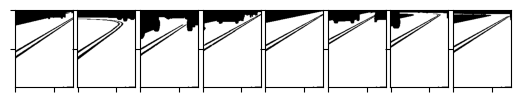

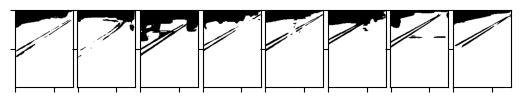

updating best checkpoint
Epoch 1 complete in 20m 58s with total training loss 1.8626454323530197


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

total validation loss = 5.188309520483017
updating best checkpoint
Epoch 2 complete in 22m 40s with total training loss 1.5106785371899605


  0%|          | 0/12 [00:00<?, ?it/s]

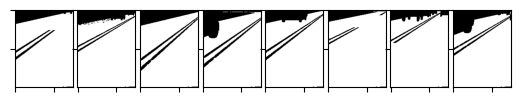

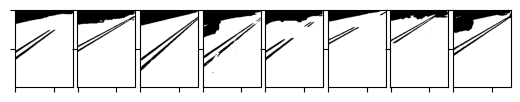

updating best checkpoint
Epoch 3 complete in 20m 35s with total training loss 1.172868862748146


  0%|          | 0/12 [00:00<?, ?it/s]

updating best checkpoint
Epoch 4 complete in 20m 32s with total training loss 0.9981475695967674


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

total validation loss = 1.0608719997107983


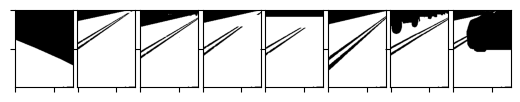

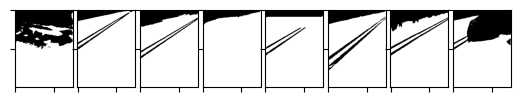

updating best checkpoint
Epoch 5 complete in 22m 24s with total training loss 0.8427685052156448


  0%|          | 0/12 [00:00<?, ?it/s]

updating best checkpoint
Epoch 6 complete in 20m 30s with total training loss 0.7299110591411591


  0%|          | 0/12 [00:00<?, ?it/s]

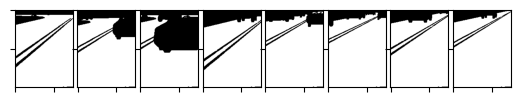

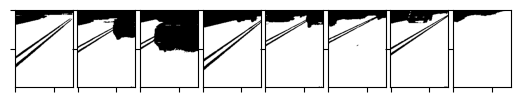

updating best checkpoint
Epoch 7 complete in 20m 34s with total training loss 0.7136271670460701


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

total validation loss = 1.2210321091115475
Epoch 8 complete in 22m 34s with total training loss 0.6507930383086205


  0%|          | 0/12 [00:00<?, ?it/s]

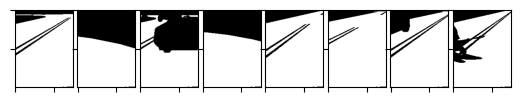

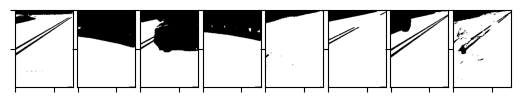

Epoch 9 complete in 20m 51s with total training loss 0.6501755379140377


In [44]:
segmentation_training.train(max_epochs=NUM_EPOCHS, 
                            continue_training=False, 
                            continue_path=None, 
                            validate_after_k=3, 
                            save_after_k=5, 
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            
                            plot_after_k=2)

In [ ]:
# CONT_PATH = '/kaggle/working/Version0/best'
# segmentation_training.train( NUM_EPOCHS, 
#                             continue_training=True,
#                             continue_path=CONT_PATH,
#                             validate_after_k=3,
#                             save_after_k=5,
#                             plot_after_k=2)

In [ ]:
# import shutil
# shutil.rmtree('/kaggle/working/Version0')

In [ ]:
############################ Blocks Definitions ##############################
                #--- contracting block ----#
def contracting_block(input_ch, output_ch, kernel_size=3, padding=1):
  '''
  This class generate a contracting block of our U-Net model

  Parameters:
    input_ch --> number of input channels
    output_ch --> output channels need
  '''
  return torch.nn.Sequential(
    torch.nn.Conv2d(input_ch, output_ch, kernel_size=kernel_size, padding=padding),
    torch.nn.BatchNorm2d(),
    torch.nn.LeakyReLU(0.2),

    torch.nn.Conv2d(output_ch, output_ch, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(),
    torch.nn.LeakyReLU(0.2),
  )
              #--- expanding block ----#
def expanding_block(input_ch, mid_ch, output_ch):
  '''
  This class generate a expanding block for our U-Net generator

  Parameters:
    input_ch-->number of input channels (final number of channels after concatenation)
    mid_ch---> number of channel in  middle of input and output of expanding block
    output_ch-->number of output channels after upsampling
  '''
  return torch.nn.Sequential(
    torch.nn.Conv2d(input_ch, mid_ch, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(),
    torch.nn.LeakyReLU(0.2),

    torch.nn.Conv2d(mid_ch, mid_ch, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(),
    torch.nn.LeakyReLU(0.2),

    torch.nn.ConvTranspose2d(mid_ch, output_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
  )
              #--- final block ----#
def final_block(input_ch, mid_ch, output_ch):
  '''
  This class generate a expanding block for our U-Net generator

  Parameters:
    input_ch-->number of input channels (final number of channels after concatenation)
    mid_ch---> number of channel in  middle of input and output of expanding block
    output_ch-->number of output channels "without" upsampling
  '''
  return torch.nn.Sequential(
    torch.nn.Conv2d(input_ch, mid_ch, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(mid_ch),
    torch.nn.LeakyReLU(0.2),

    torch.nn.Conv2d(mid_ch, mid_ch, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(mid_ch),
    torch.nn.LeakyReLU(0.2),

    torch.nn.Conv2d(mid_ch, output_ch, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(output_ch),
    torch.nn.LeakyReLU(0.2),

    #torch.nn.Tanh()
  )

class U_Net(torch.nn.Module):
  def __init__(self, input_ch, output_ch, dim=32):
    super(U_Net, self).__init__()
    self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = torch.nn.Dropout()

    ######################### creating Blocks ##################################
                #--- contracting ----#
    self.c1 = contracting_block(input_ch, 2*dim) # 3-64-64
    self.c2 = contracting_block(2*dim, 4*dim) #64-128-128
    self.c3 = contracting_block(4*dim, 8*dim) #128-256-256
    self.c4 = contracting_block(8*dim, 16*dim) # 256-512-512
                #--- bottel neck ----#
    self.b = expanding_block(16*dim, 32*dim, 16*dim) #512-1024-1024-512
                #--- expanding ----#
    self.e1 = expanding_block(32*dim, 16*dim, 8*dim) #1024-512-512-256
    self.e2 = expanding_block(16*dim, 8*dim, 4*dim) #512-256-256-128
    self.e3 = expanding_block(8*dim, 4*dim, 2*dim) #256-128-128-64
                #--- final block ----#
    self.f = final_block(4*dim, 2*dim, output_ch) #128-64-64-3

  ############################ forward method ##################################
  def forward(self, x):
    x1 = self.c1(x)
    mpx1 = self.maxpool(x1)
    x2 = self.c2(mpx1)
    mpx2 = self.maxpool(x2)
    x3 = self.c3(mpx2)
    mpx3 = self.maxpool(x3)
    x4 = self.c4(mpx3)
    mpx4 = self.maxpool(x4)

    xb = self.b(mpx4)
    xb = self.dropout(xb)

    ex1 = self.e1(torch.cat([xb, x4], axis=1))
    ex1 = self.dropout(ex1)
    ex2 = self.e2(torch.cat([ex1, x3], axis=1))
    ex3 = self.e3(torch.cat([ex2, x2], axis=1))

    f = self.f(torch.cat([ex3, x1], axis=1))
    return f;